# 🚀 Next 5 Minutes

Now you've learned the basics -- now we demonstrate why Trace can be the fundamental basic block to build increasingly complex agent systems.

Trace supports building agents can rewrite its own rules, logic, and behaviors. Self-modification is the key design idea of Trace. Trace agents self-evolve by embedding the philosophy of *trial-and-error* (the Reinforcement Learning way!). A Trace agent first proposes a solution, tries this solution out, receives feedback, and then improve. This propose-feedback-improve loop is at the heart of policy gradient algorithms (such as [PPO](https://arxiv.org/abs/1707.06347), which is used in RLHF -- Reinforcement Learning from Human Feedback). The ability to modify its own behavior is the core of an intelligent system.

Although LLMs can generate code, actions, or anything a human can, controlling what they generate is not as easy. Trace takes the programmer's approach -- an intelligent system is made of a series of coding blocks, some of which might make an LLM call, but others might access a database, or scrap a web page. Human engineers are great at writing these kinds of systems. In order for these systems to be "intelligent" -- human engineers need to add many corner cases to be "reactive" to different inputs.

In [1]:
import opto.trace as trace
from opto.trace import node, bundle, model, GRAPH
from opto.optimizers import OptoPrime

Trace uses decorators like `@bundle` or `@model` and data wrappers like `node` to expose different parts of these programs to an LLM. An LLM can rewrite the entire or only parts of system based on the user's specification. An LLM can change various parts of this system, with feedback they receive from the environment. Trace allows users to exert control over the LLM generation process.

A simple example of how Trace allows the user to design an agent, and how the agent self-modifies its own behavior to adapt to the environment, we can take a look at the classic game of Battleship.

```{image} ../images/dall_e_battleship.jpeg
:alt: battleship
:class: bg-primary mb-1
:align: center
```

(Image credit: DALL-E by OpenAI)

We already implemented a simplified version of the battleship game. The game's rule is straightforward: our opponent has placed 8 ships on a square board. The ships vary in size, resembling a carrier, battleship, cruiser, submarine, and destroyer. We need to select a square to hit during each turn.

In [4]:
from examples.battleship import BattleshipBoard

board = BattleshipBoard(8, 8)

# Show the ini+tial board with ships
board.render_html(show_ships=True)

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


Of course, this wouldn't be much of a game if we are allowed to see all the ships laying out on the board -- then we would know exactly which square to place a shot! After we choose a square to place a shot, our opponent will reveal whether the shot is a hit or a miss!

In [5]:
# Make some shots
board.check_shot(0, 0)
board.check_shot(1, 1)
board.check_shot(2, 2)

# Show the board after shots
board.render_html(show_ships=False)

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


We can write a simple agent that can play this game. Note that we are creating a normal Python class and decorate it with `@model`, and then use `@bundle` to specify which part of this class can be changed by an LLM through feedback.

In [9]:
@model
class Agent:

    def __call__(self, map):
        return self.select_coordinate(map).data

    def act(self, map):
        plan = self.reason(map)
        output = self.select_coordinate(map, plan)
        return output

    @bundle(trainable=True)
    def select_coordinate(self, map, plan):
        """
        Given a map, select a target coordinate in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        """
        return None

    @bundle(trainable=True)
    def reason(self, map):
        """
        Given a map, analyze the board in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        """
        return None

Just like in the previous tutorial, we need to define a feedback function to provide the guidance to the agent to self-improve. We make it simple -- just telling the agent how much reward they obtained form the game environment.

In [2]:
# Function to get user feedback for placing shot
def user_fb_for_placing_shot(board, coords):
    try:
        reward = board.check_shot(coords[0], coords[1])
        new_map = board.get_shots()
        terminal = board.check_terminate()
        return new_map, int(reward), terminal, f"Got {int(reward)} reward."
    except Exception as e:
        return board.get_shots(), 0, False, str(e)

We can first take a look at what the Trace graph looks like for this agent when it takes an observation `board.get_shots()` from the board (this shows the map without any ship but with past records of hits and misses). The agent takes an action based on this observation.

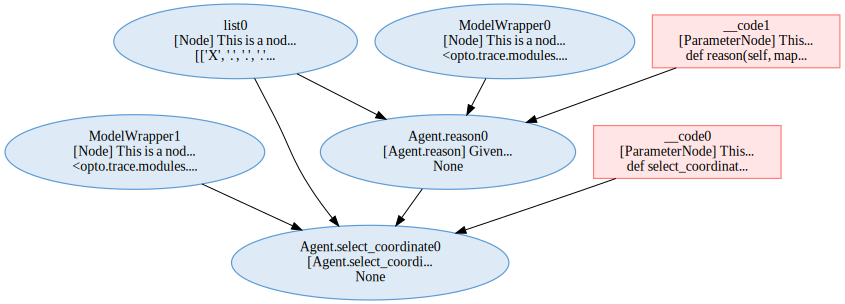

In [28]:
GRAPH.clear()

agent = Agent()
obs = node(board.get_shots(), trainable=False)
output = agent.act(obs)
output.backward(visualize=True, print_limit=20)

We can see that, this is the execution graph (Trace graph) that transforms the observation (marked as `list0`) to the output (marked as `select_coordinate0`). Trace opens up the blackbox of how an input is transformed to an output in a system. 

```{note}
Note that not all parts of the agent are present in this graph. For example, `__call__` is not in this. A user needs to decide what to include and what to exclude, and what's trainable and what's not. You can learn more about how to design an agent in the tutorials.
```

Now let's see if we can get an agent that can play this game with environment reward information.

In [4]:
import autogen
from opto.trace.utils import render_opt_step
from examples.battleship import BattleshipBoard

GRAPH.clear()

board = BattleshipBoard(8, 8)
board.render_html(show_ships=True)

agent = Agent()
obs = node(board.get_shots(), trainable=False)
optimizer = OptoPrime(agent.parameters(), config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

feedback, terminal, cum_reward = "", False, 0

iterations = 0
while not terminal and iterations < 10:
    try:
        output = agent.act(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
        hint = f"The current code gets {reward}. We should try to get as many hits as possible."
        optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
    except trace.ExecutionError as e:
        output = e.exception_node
        feedback, terminal, reward = output.data, False, 0

    board.render_html(show_ships=False)

    cum_reward += reward

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    optimizer.step(verbose=False)

    render_opt_step(iterations, optimizer, no_trace_graph=True)
    iterations += 1

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


In [5]:
for p in agent.parameters():
    print(p.data)
    print()

def reason(self, map):
    
    def count_targets(grid, target='.'):
        count = 0
        for row in grid:
            count += row.count(target)
        return count
    return count_targets(map)

def select_coordinate(self, map, plan):
        """
        Given a map, select a target coordinate in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        This function selects a strategically beneficial unknown coordinate, considering surrounding hits and misses and the detailed plan from previous evaluations.
        """
        import random
        def find_unknown(grid):
            return [(i, j) for i, row in enumerate(grid) for j, cell in enumerate(row) if cell == '.']
        def find_strategic_unknown(grid, plan):
            strategic_unknowns = []
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            for i, row in enumerate(grid):
                for j, cell in enumerate(row):
                    if cell == 

Then we can see how this agent performs in an evaluation run.

In [8]:
board = BattleshipBoard(8, 8)
board.render_html(show_ships=True)

terminal = False
for _ in range(15):
    try:
        output = agent.act(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
    except trace.ExecutionError as e:
        # this is essentially a retry
        output = e.exception_node
        feedback = output.data
        terminal = False
        reward = 0

    board.render_html(show_ships=False)
    if terminal:
        break

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,
